In [1]:
# based on https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/data

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import os
import tensorflow as tf

from imgaug import augmenters as iaa

from PIL import Image

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from multiprocessing import Pool


# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../train2017/'
TEST_PATH = '../../PennFudanPed/TEST/'
MASK_PATH  = 'PedMasks/LIP'

IMAGE_PATH = 'PNGImages/LIP'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
dataType='train2017'
dataDir='/home/silentium/train2017'
annFile='/home/silentium/Pulpit/annotations/instances_train2017.json'.format(dataDir,dataType)

In [4]:
coco=COCO(annFile)
#coco api https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb


loading annotations into memory...
Done (t=15.17s)
creating index...
index created!


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
food kitchen person appliance furniture electronic sports outdoor indoor animal vehicle accessory


In [6]:
train_img_ids = next(os.walk(TRAIN_PATH))[2]

#train_mask_ids = next(os.walk(TRAIN_PATH + MASK_PATH))[2]

test_img_ids = next(os.walk(TEST_PATH + 'PNGImages'))[2]

In [7]:
car_img_Ids = set(coco.getImgIds(catIds=coco.getCatIds(catNms=['car']) ) )
persons_img_Ids = set( coco.getImgIds(catIds=coco.getCatIds(catNms=['person']) ) )
knifes_img_Ids = set( coco.getImgIds(catIds=coco.getCatIds(catNms=['knife']) ) )

ids_tab = {'car':car_img_Ids, "person":persons_img_Ids, "knife":knifes_img_Ids}

desired_class_name = 'person'
desired_ids = ids_tab[desired_class_name]


desired_catIds = coco.getCatIds(catNms=[ids_tab[desired_class_name]]);

ids_set = set(ids_tab.keys())

ids_set_without = ids_set.difference(set([desired_class_name]) )

list_ids_set_without = list(ids_set_without)

print(len(desired_ids))

desired_ids = desired_ids.difference(ids_tab[list_ids_set_without[0]])
print(len(desired_ids))
desired_ids = desired_ids.difference(ids_tab[list_ids_set_without[1]])
desired_ids = list(desired_ids)
print(len(desired_ids))

64115
55596
53287


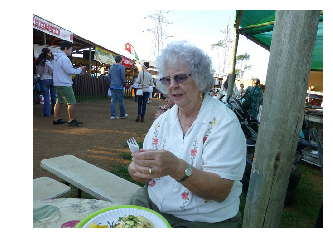

17
[1]
1
1
1
1
48
1
31
31
1
1
31
31
85
67
1
15
15


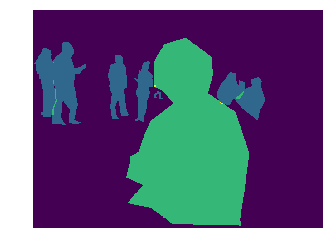

In [65]:

img = coco.loadImgs(desired_ids[np.random.randint(0,len(desired_ids))])[0]


I = io.imread('../../train2017/'+img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()
plt.imshow(I); plt.axis('off')

annIds = coco.getAnnIds(imgIds=img['id'],catIds=desired_catIds, iscrowd=False)


anns = coco.loadAnns(annIds)
#coco.showAnns(anns)
mask = coco.annToMask(anns[0])
print(len(anns))
print(coco.getCatIds(catNms=desired_class_name))
for i, ann in enumerate(anns):
    print(ann['category_id'])
    if ann['category_id'] == coco.getCatIds(catNms=desired_class_name)[0]:
        mask += coco.annToMask(ann)
plt.imshow(mask)

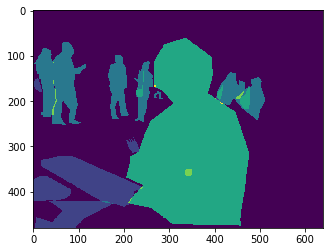

In [66]:
for i, ann in enumerate(anns):
        mask += coco.annToMask(ann)
plt.imshow(mask)

In [39]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(anns)

[   {   'area': 6605.876100000001,
        'bbox': [43.49, 127.84, 84.3, 109.53],
        'category_id': 41,
        'id': 639775,
        'image_id': 536896,
        'iscrowd': 0,
        'segmentation': [   [   120.27,
                                147.17,
                                127.79,
                                212.13,
                                124.03,
                                226.63,
                                125.1,
                                237.37,
                                112.21,
                                235.76,
                                110.07,
                                229.85,
                                63.89,
                                230.92,
                                62.28,
                                236.83,
                                49.4,
                                236.83,
                                50.47,
                                229.85,
                         

In [9]:

X_train = np.zeros((len(desired_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(desired_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
'''

for iteration_number in tqdm_notebook( range(len(desired_ids) ) ):
    
    imgIds = desired_ids
    img = coco.loadImgs(desired_ids[np.random.randint(0,len(imgIds))])[0]
    #print(img)
    
    I = io.imread('../../train2017/'+img['file_name'])

    im = Image.fromarray(I)
    im.save('../../multimedia_datasets/'+desired_class_name+'/images/'+str(iteration_number)+'.png')
    
    annIds = coco.getAnnIds(imgIds=img['id'],catIds=desired_catIds, iscrowd=False)
    #print(annIds)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])
    
    mask_image = Image.fromarray(mask)
    mask_image.save('../../multimedia_datasets/'+desired_class_name+'/masks/'+str(iteration_number)+'.png')
'''

"\n\nfor iteration_number in tqdm_notebook( range(len(desired_ids) ) ):\n    \n    imgIds = desired_ids\n    img = coco.loadImgs(desired_ids[np.random.randint(0,len(imgIds))])[0]\n    #print(img)\n    \n    I = io.imread('../../train2017/'+img['file_name'])\n\n    im = Image.fromarray(I)\n    im.save('../../multimedia_datasets/'+desired_class_name+'/images/'+str(iteration_number)+'.png')\n    \n    annIds = coco.getAnnIds(imgIds=img['id'],catIds=desired_catIds, iscrowd=False)\n    #print(annIds)\n    anns = coco.loadAnns(annIds)\n    coco.showAnns(anns)\n    mask = coco.annToMask(anns[0])\n    for i in range(len(anns)):\n        mask += coco.annToMask(anns[i])\n    \n    mask_image = Image.fromarray(mask)\n    mask_image.save('../../multimedia_datasets/'+desired_class_name+'/masks/'+str(iteration_number)+'.png')\n"

In [10]:



def f(one_ids):

    imgIds = desired_ids
    img = coco.loadImgs(one_ids)[0]
    #print(img)

    I = io.imread('../../train2017/'+img['file_name'])

    im = Image.fromarray(I)
    im.save('../../multimedia_datasets/'+desired_class_name+'/images/'+str(one_ids)+'.png')

    annIds = coco.getAnnIds(imgIds=img['id'],catIds=desired_catIds, iscrowd=False)
    anns = coco.loadAnns(annIds)

    mask = coco.annToMask(anns[0])
    for i in range(len(anns)):
        mask += coco.annToMask(anns[i])

    mask_image = Image.fromarray(mask)
    mask_image.save('../../multimedia_datasets/'+desired_class_name+'/masks/'+str(one_ids)+'.png')

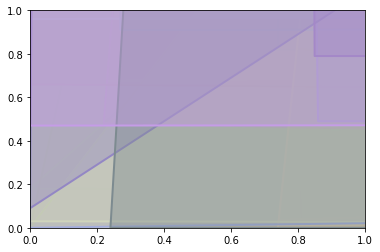

In [11]:
for ids in tqdm_notebook(desired_ids):
    f(ids)